In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

np.set_printoptions(suppress=True)

import sys, os
sys.path.append("../src")

from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior_gp, length_scale_prior
from micro_models import dynamic_batch_diffusion
from networks_10092022 import DynamicGaussianNetworkJoint
from context import generate_design_matrix
from transformations import unscale_z

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
from tensorflow.keras.layers import GRU, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

In [4]:
from tqdm.notebook import tqdm
from functools import partial

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))


# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-25 16:08:39.539595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:08:39.569143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:08:39.569322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Constants

In [6]:
T = 3200
DIST_MAT = build_distance_matrix(T)
AMPLITUDES = [0.25, 0.25, 0.25, 0.25, 0.25, 0.15]
BATCH_SIZE = 16
TEST_SIZE = 10
N_CHUNKS = 4000
EPOCHS = 100

2022-10-25 16:08:39.606908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 16:08:39.607440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:08:39.607625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 16:08:39.607756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
PARAMS_MEAN = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
               1.6, 1.6, 1.6, 1.6, 1.6, 0.5]
PARAMS_STD = [5.7, 5.7, 5.7, 5.7, 5.7 , 5.7,
              1.75, 1.75, 1.75, 1.75, 1.75, 0.6]

## Network

In [8]:
def generator_fun(batch_size):
    theta0 = diffusion_prior_gp(batch_size, n_cond=4)
    eta = length_scale_prior(batch_size, 6)
    eta_t = np.stack([eta] * T, axis=1)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    params_t = np.concatenate([eta_t, theta_t], axis=-1)
    params_t_z = (params_t - PARAMS_MEAN) / PARAMS_STD
    
    return params_t_z.astype(np.float32), x.astype(np.float32)

In [9]:
def presimulate_data():
    for n in range(N_CHUNKS):
        params_t_z, x = generator_fun(BATCH_SIZE)
        np.save(f'../data/offline_data/data/x_{n}.npy', x)
        np.save(f'../data/offline_data/parameters/parameters_{n}.npy', params_t_z)

In [10]:
# presimulate_data()

In [11]:
class ChunkLoader:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.data_list = sorted(os.listdir(os.path.join(path_to_data, 'data')), key=lambda f: int(re.sub('\D', '', f)))
        self.params_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters')), key=lambda f: int(re.sub('\D', '', f)))
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.num_batches = len(self.data_list)
        self.current_index = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_index < self.num_batches:
            self.current_index += 1
            idx = self.indices[self.current_index -1]
            batch_x = np.load(os.path.join(self.path_to_data, 'data', self.data_list[idx]))
            batch_params = np.load(os.path.join(self.path_to_data, 'parameters', self.params_list[idx]))
            return batch_params, batch_x
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.current_index = 0
        raise StopIteration

In [12]:
loader = ChunkLoader('../data/offline_data')

In [13]:
network = Sequential([
    GRU(128, return_sequences=True),
    LSTM(128, return_sequences=True),
    Dense(128, activation='elu'),
    Dense(tfpl.IndependentNormal.params_size(12)),
    tfpl.IndependentNormal(12)
])
steps_per_epoch = 500
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=2500,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [14]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [15]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step, batch in enumerate(generator):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            params_t_z, data = batch
            
            idx = np.random.choice(np.arange(0, 16), size=8, replace=False, p=None)

            # Forward pass
            posterior = network(data[idx])

            # loss computation
            loss = nll(params_t_z[idx], posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [16]:
# def train_epoch(network, optimizer, dataset, batch_size, p_bar, mmd_weight=0.1):
#     """ Helper function for one simulation epoch. """
    
#     losses = []
#     for bi, (data, params) in enumerate(dataset):
#         with tf.GradientTape() as tape:
#             params_pred = network(data)
#             params_z = (params - params_mean) / params_std
#             loss = nll(params_z, params_pred)
            
#         # Backprop step
#         g = tape.gradient(loss, network.trainable_variables)
#         optimizer.apply_gradients(zip(g, network.trainable_variables))
#         losses.append(loss.numpy())

#         # Update progress bar
#         p_bar.set_postfix_str("Batch {},Loss: {:.3f},Avg.Loss: {:.3f}"
#                               .format(bi+1, loss.numpy() , np.mean(losses)))
#         p_bar.update(1)
#     return losses

In [18]:
losses = []
for ep in range(1, EPOCHS+1):
    with tqdm(total=loader.num_batches, desc=f'Training Epoch {ep}') as p_bar:
        loss_ep = epoch_trainer(loader, network, optimizer, steps_per_epoch, p_bar)
        losses.append(loss_ep)
    network.save_weights('../trained_networks/gp_ddm_3200_joint_offline')

Training Epoch 1:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 21:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 22:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 23:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 24:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 25:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 26:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 27:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 28:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 29:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 30:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 31:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 32:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 33:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 34:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 35:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 36:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 37:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 38:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 39:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 40:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 41:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 42:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 43:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 44:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 45:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 46:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 47:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 48:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 49:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 50:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 51:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 52:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 53:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 54:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 55:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 56:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 57:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 58:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 59:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 60:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 61:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 62:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 63:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 64:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 65:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 66:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 67:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 68:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 69:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 70:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 71:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 72:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 73:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 74:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 75:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 76:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 77:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 78:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 79:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 80:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 81:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 82:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 83:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 84:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 85:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 86:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 87:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 88:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 89:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 90:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 91:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 92:   0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validation

In [ ]:
# network.load_weights('../trained_networks/gp_ddm_3200_joint')

## Gen Test Data

In [ ]:
# theta0 = diffusion_prior_gp(TEST_SIZE, n_cond=1)
# eta = length_scale_prior(TEST_SIZE, 3)
# theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
# rt_test = simple_batch_diffusion(theta_test).astype(np.float32)

In [19]:
params_test, x_test = generator_fun(TEST_SIZE)

## Predict

In [20]:
preds = network(x_test)

In [29]:
theta_means = preds.mean()[:, :, 6:]  * PARAMS_STD[6:] + PARAMS_MEAN[6:]
theta_stds = preds.stddev()[:, :, 6:] * PARAMS_STD[6:]
theta_test = params_test[:, :, 6:] * PARAMS_STD[6:] + PARAMS_MEAN[6:]

##  Visualize Predictions Over Time

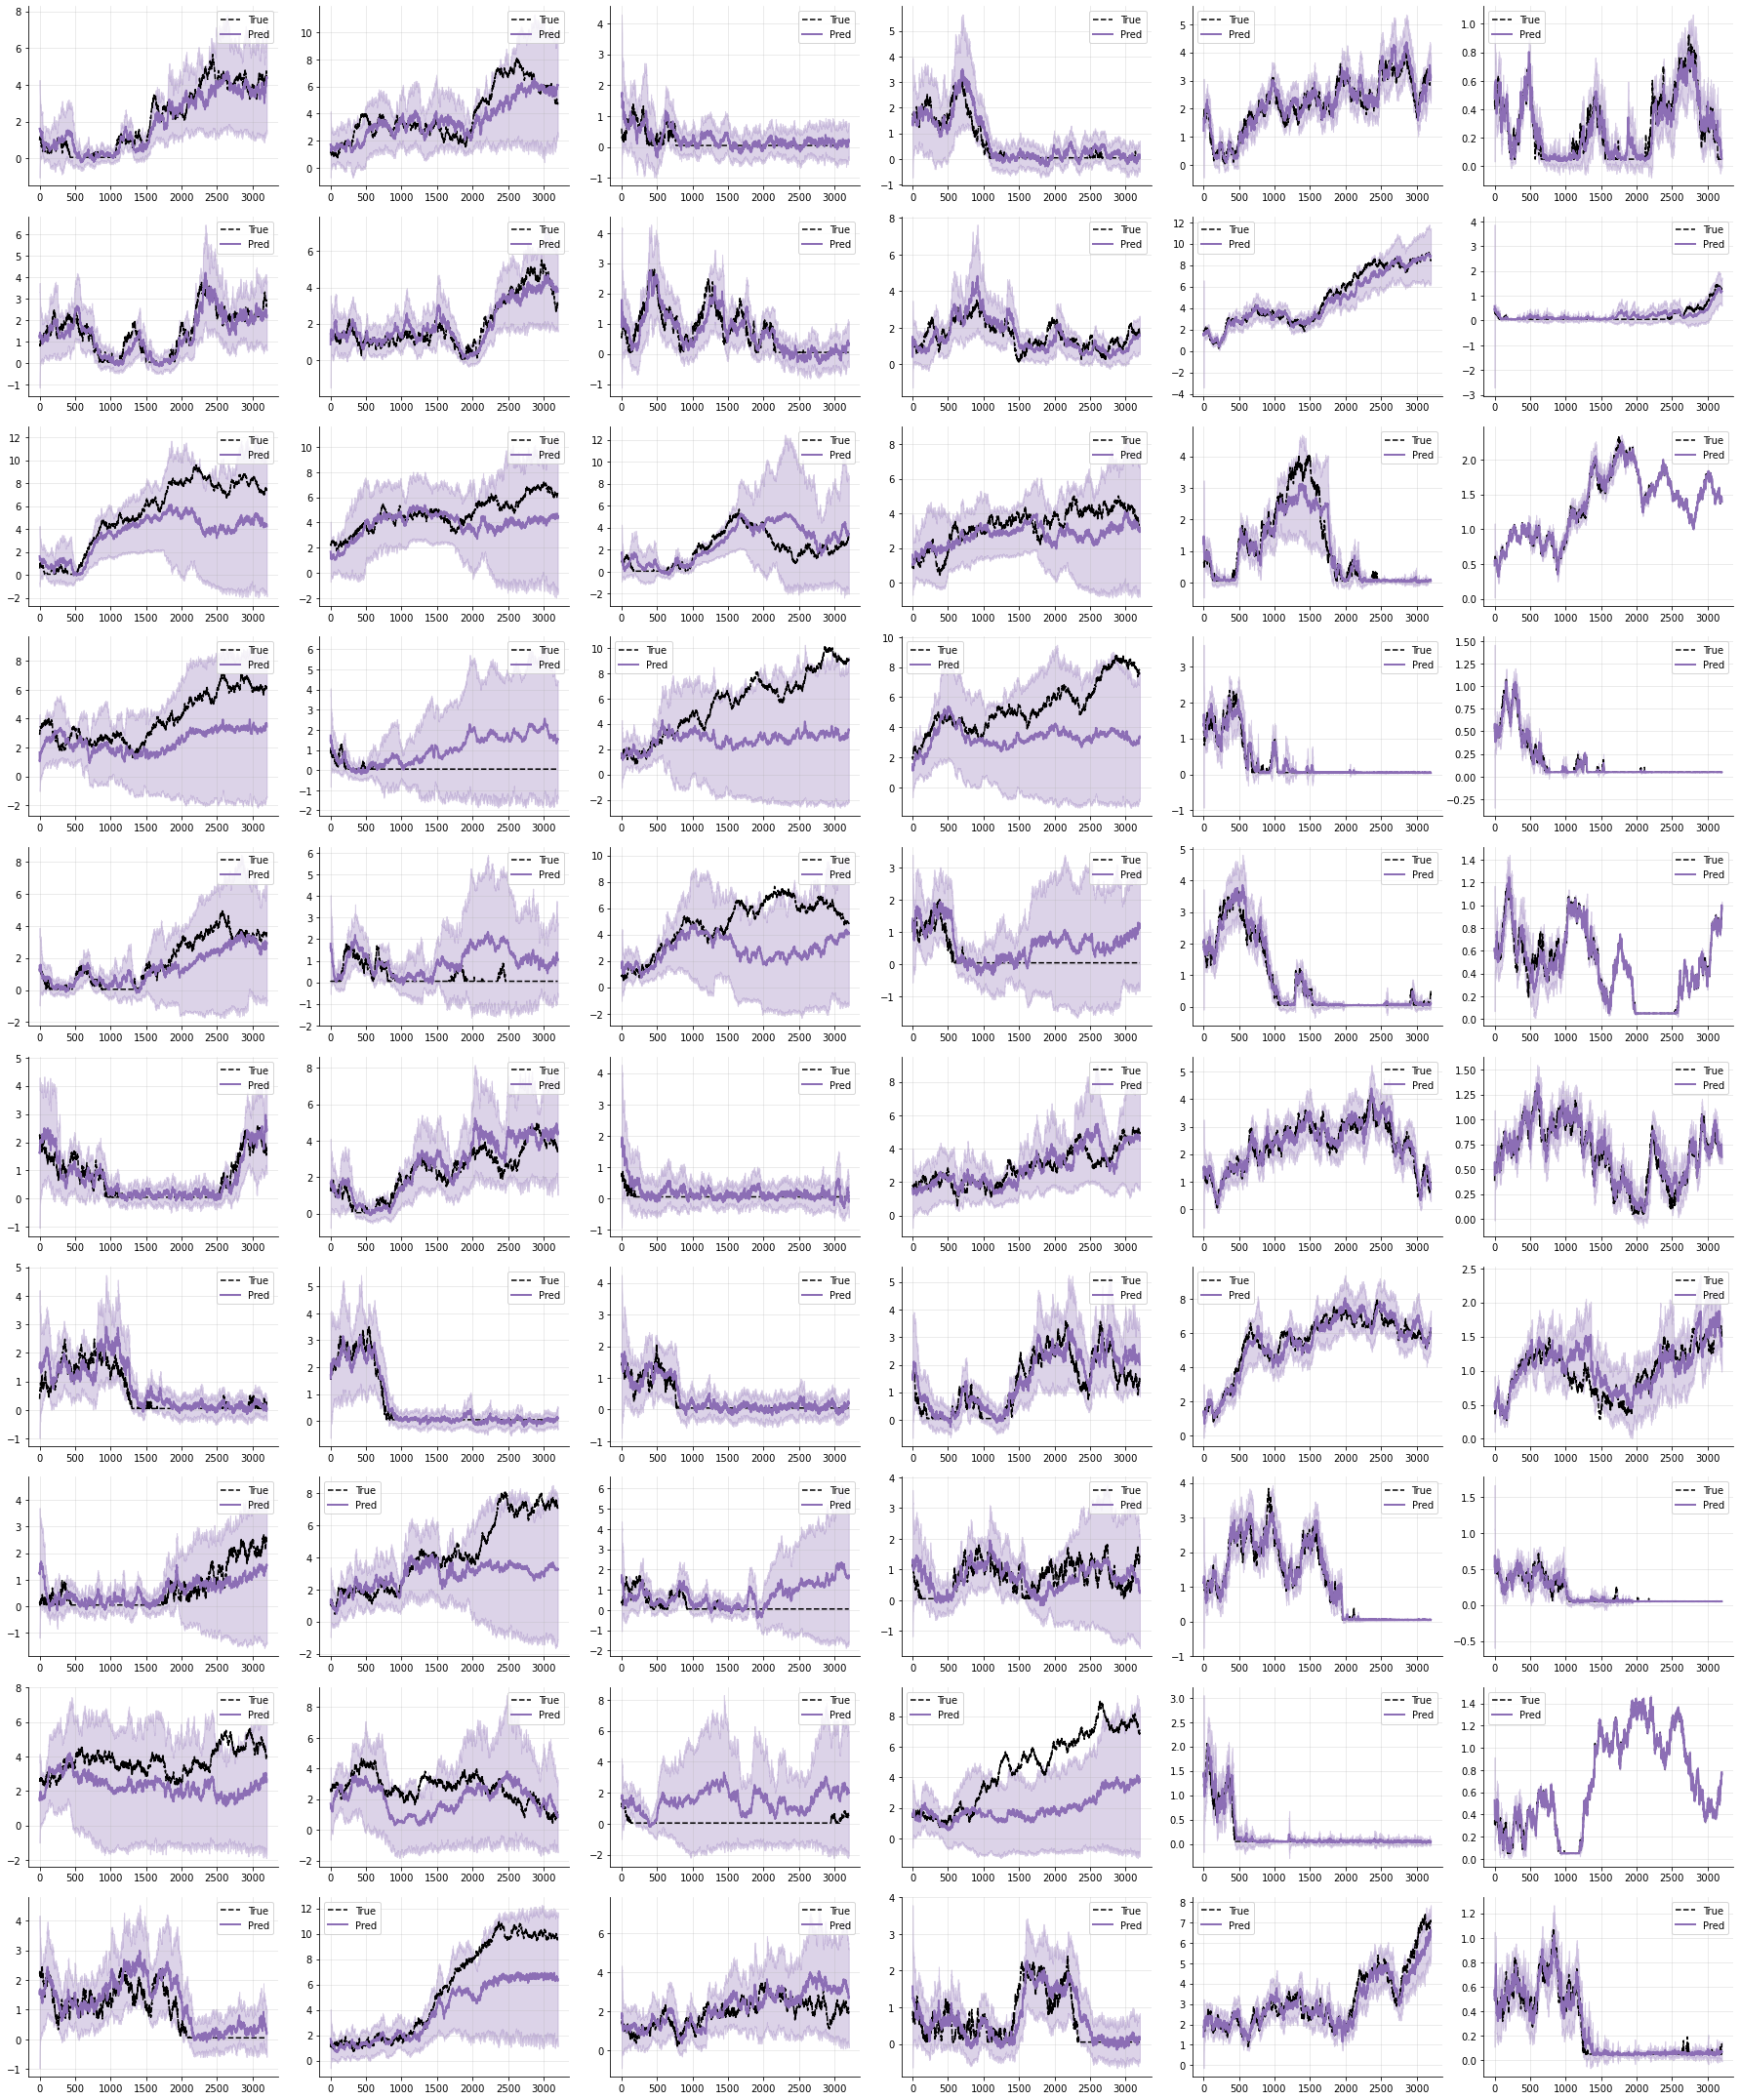

In [30]:
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 2
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        ax.plot(time, theta_test[j, :, i], label='True', color='black', linestyle='dashed')
        ax.plot(time, theta_means[j, :, i], label='Pred', lw=2, color='#8c6eb5')
        ax.fill_between(time, 
                        theta_means[j, :, i] + std_mul * theta_stds[j, :, i], 
                        theta_means[j, :, i] - std_mul * theta_stds[j, :, i], color='#8c6eb5', alpha=0.3)
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()

In [ ]:
post_samples = preds.sample(100)
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 2
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        sns.kdeplot(post_samples[:, j, -1, i], ax=ax, fill='maroon')
        ax.axvline(params_test[j, -1, i], color='red')

## Visualize Slices

In [ ]:
VAL_SIZE = 300
theta0 = diffusion_prior_gp(VAL_SIZE, n_cond=1)
eta = length_scale_prior(VAL_SIZE, 3)
theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
rt_test = simple_batch_diffusion(theta_test).astype(np.float32)
SLICE_POINTS = [2, 50, 100]

In [ ]:
theta_preds = network(rt_test)
theta_means = theta_preds.mean().numpy() * PARAMS_STD + PARAMS_MEAN
theta_stds = theta_preds.stddev().numpy() * PARAMS_STD

In [ ]:
f, axarr = plt.subplots(len(SLICE_POINTS), 3, figsize=(10, 10))
for j in range(len(SLICE_POINTS)):
    for i in range(3):
        ax = axarr[j, i]
        true = theta_test[:, SLICE_POINTS[j]-1, i]
        pred = theta_means[:, SLICE_POINTS[j]-1, i]
        std = theta_stds[:, SLICE_POINTS[j]-1, i]
        ax.errorbar(true, pred, yerr=std, fmt='o', alpha=0.5, color='#8c6eb5')
        # ax.scatter(true, pred, color='#8c6eb5')
        sns.despine(ax=ax)
        ax.grid(alpha=0.3)
        
        lower = min(true.min(), pred.min())
        upper = max(true.max(), pred.max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps]) 
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], 
                 color='black', alpha=0.9, linestyle='dashed')
        ax.set_xlabel('True')
        ax.set_ylabel('Estimated mean')
        if i == 0:
            ax.text(-0.5, 0.5, f'T={SLICE_POINTS[j]}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
f.tight_layout()